## Day 1 Tutorial Outlines

### QFT with Yao

### Variational Quantum Eigensolver (VQE) using automatic differentiation

In this example, we will go through the most straightforward variational quantum algorithm to learn how to use automatic differentiation.

## Day 1 Hands-on Task

1. find the corresponding U(4) gate parameter of given gate set
2. find the ground state of the following hamiltonian (Rydberg Hamiltonian) on a chain lattice using imaginary time evolution/eigensolver/VQE

$$
\sum \frac{V}{|r_i-r_j|^6} n_i n_j + \Omega \sum_i X_i - \Delta \sum_i n_i
$$

3. bounty issue (https://github.com/QuantumBFS/Yao.jl/issues/403)
4. explore other notebooks


now let's quickly define a quantum fourier transform circuit using the blocks we just learned (same example from Yao's README)

In [13]:
A(i, j) = control(i, j=>shift(2π/(1<<(i-j+1))))
B(n, k) = chain(n, j==k ? put(k=>H) : A(j, k) for j in k:n)
qft(n) = chain(B(n, k) for k in 1:n)

qft (generic function with 1 method)

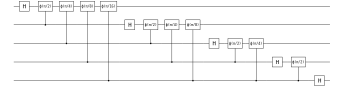

In [14]:
plot(qft(5))

In [1]:
using Yao, YaoPlots

# The Quantum Blocks of Yao

quantum blocks are symbolic expression for quantum operators in Yao, especially for quantum circuits, there are two kind of quantum blocks in general

- the primitive blocks
- the composite blocks

for example, the Pauli X operator is a `PrimitiveBlock`

In [2]:
X isa PrimitiveBlock

true

In [3]:
?X

search: X xor XGate Rx exp Expr exp2 exit axes expm1 exp10 export expect extrema



```
X
XGate <: ConstantGate{1,2}
```

Pauli X gate. `X` is the instance of `XGate`.


or you can also have primitive blocks that contain parameters, e.g rotation on the X axis (Rx gate)

In [4]:
Rx(0.1)

rot(X, 0.1)

In [5]:
?Rx

search: Rx frexp Matrix IMatrix isapprox BitMatrix DenseMatrix applymatrix



```
Rx(theta)
```

Return a [`RotationGate`](@ref) on X axis.

# Example

```jldoctest; setup=:(using YaoBlocks)
julia> Rx(0.1)
rot(X, 0.1)
```


then using composite blocks, you can compose other blocks together with your own abstractions, for example, we can chain two X gate together

In [6]:
chain(X, Y)

nqubits: 1
chain
├─ X
└─ Y

this is equivalent to the following mathematical expression

$$
Y \cdot X
$$

here let's discuss the printing results a bit, the printing indicates the tree structure of your circuit expression, e.g you can have the following different structure for the same circuit

In [7]:
chain(X, Y, Z)

nqubits: 1
chain
├─ X
├─ Y
└─ Z

In [8]:
chain(chain(X, Y), Z)

nqubits: 1
chain
├─ chain
│  ├─ X
│  └─ Y
└─ Z

we can use the `plot` function from `YaoPlots` to visualize the circuit

In [9]:
plot(chain(X, Y, Z))

if you want to put gate on different wires, you can use the `put` block

$$
\texttt{put(n, i=>G)} = I^{\otimes n-i} \otimes G \otimes I^{\otimes i-1}
$$

In [10]:
chain(4, put(1=>X), put(3=>X))

nqubits: 4
chain
├─ put on (1)
│  └─ X
└─ put on (3)
   └─ X


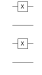

In [11]:
plot(chain(4, put(1=>X), put(3=>X)))

$$
{\rm shift}(\theta) = \begin{pmatrix}
1 & 0\\
0 & e^{i\theta}
\end{pmatrix}
$$

and you can define a control gate, using the `control` block, e.g a control shift can be defined as

In [12]:
control(3, 2, 1=>shift(0.1))

nqubits: 3
control(2)
└─ (1,) shift(0.1)

here the first argument `3` denotes the total number of qubits, the second argument `2` denotes the control qubit location, the last argument `1=>shift(0.1)` denotes the operator to be controlled and its location.

here `A` denotes the control shift block, calling `control` without filling total number of qubits will result in creating a function that takes total number of qubits

In [15]:
A(2, 1)

(n -> control(n, 2, 1 => shift(1.5707963267948966)))

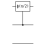

In [16]:
plot(A(2, 1)(3))

and `B` block creates a wrap of the small repeated units at different sizes

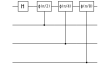

In [17]:
plot(B(4, 1))

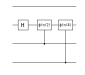

In [18]:
plot(B(4, 2))

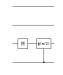

In [19]:
plot(B(4, 3))

then in the end by chaining them together we obtain the complete QFT circuit

In Yao, most of the blocks has a corresponding matrix representation, you can retreive them using the `mat` method,

In [20]:
mat(qft(3))

8×8 SparseMatrixCSC{ComplexF64, Int64} with 64 stored entries:
 0.353553+0.0im   0.353553+0.0im  …      0.353553+0.0im
 0.353553+0.0im  -0.353553+0.0im             0.25-0.25im
 0.353553+0.0im   0.353553+0.0im     -2.16489e-17-0.353553im
 0.353553+0.0im  -0.353553+0.0im            -0.25-0.25im
 0.353553+0.0im   0.353553+0.0im        -0.353553+0.0im
 0.353553+0.0im  -0.353553+0.0im  …         -0.25+0.25im
 0.353553+0.0im   0.353553+0.0im      2.16489e-17+0.353553im
 0.353553+0.0im  -0.353553+0.0im             0.25+0.25im

here is another example of GHZ state preparation circuit

In [21]:
circuit = chain(
    4,
    put(1=>X),
    repeat(H, 2:4),
    control(2, 1=>X),
    control(4, 3=>X),
    control(3, 1=>X),
    control(4, 3=>X),
    repeat(H, 1:4),
)

nqubits: 4
chain
├─ put on (1)
│  └─ X
├─ repeat on (2, 3, 4)
│  └─ H
├─ control(2)
│  └─ (1,) X
├─ control(4)
│  └─ (3,) X
├─ control(3)
│  └─ (1,) X
├─ control(4)
│  └─ (3,) X
└─ repeat on (1, 2, 3, 4)
   └─ H


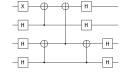

In [22]:
plot(circuit)

### The Registers

the register serve as an abstraction for quantum devices with some mutable internal states. To be more specific, the type of register we will be using is the `ArrayReg` which contains a large dense array storing the state vector for simulation.

By using different kind of register type, we will be able to switch between different type of simulation, or hardware. In tomorrow's tutorial, we will see another type of register which is the `SubspaceArrayReg` for Rydberg system simulation using blockade approximation.

Creating a register is however very simple

In [23]:
reg = zero_state(4)

ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2

creates a 5-qubit register with its internal state set to $|00000\rangle$, we can then apply the quantum circuit to the register using `apply!`, note the `!` mark here denotes that this method will change the internal state of our register (in general case, this type of operation is called the in-place operation)

In [24]:
apply!(reg, circuit)

ArrayReg{2, ComplexF64, Array...}
    active qubits: 4/4
    nlevel: 2

now if we inspect the internal statevector of this register, it becomes the GHZ state

In [25]:
statevec(reg)

16-element Vector{ComplexF64}:
  0.7071067811865471 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
 -0.7071067811865471 + 0.0im

or we can also run measurement on the register

In [26]:
measure(reg; nshots=100)

100-element Vector{DitStr{2, 4, Int64}}:
 0000 ₍₂₎
 1111 ₍₂₎
 0000 ₍₂₎
 0000 ₍₂₎
 0000 ₍₂₎
 0000 ₍₂₎
 1111 ₍₂₎
 0000 ₍₂₎
 0000 ₍₂₎
 1111 ₍₂₎
 0000 ₍₂₎
 1111 ₍₂₎
 1111 ₍₂₎
        ⋮
 1111 ₍₂₎
 1111 ₍₂₎
 0000 ₍₂₎
 1111 ₍₂₎
 1111 ₍₂₎
 1111 ₍₂₎
 1111 ₍₂₎
 0000 ₍₂₎
 1111 ₍₂₎
 1111 ₍₂₎
 1111 ₍₂₎
 1111 ₍₂₎

### Variational Eigen Solvers with Yao

In this example we will be solving the following heisenburg Hamiltonian

$$
\sum_{\langle i j \rangle} X_i X_j + Y_i Y_j + Z_i Z_j
$$

you can create this hamiltonian directly by adding up the operators in Yao

In [42]:
L = 5
h = sum(chain(L, put(i=>X), put(mod1(i+1, L)=>X)) for i in 1:L) +
    sum(chain(L, put(i=>Y), put(mod1(i+1, L)=>Y)) for i in 1:L) +
sum(chain(L, put(i=>Z), put(mod1(i+1, L)=>Z)) for i in 1:L)

nqubits: 5
+
├─ +
│  ├─ +
│  │  ├─ +
│  │  │  ├─ +
│  │  │  │  ├─ chain
│  │  │  │  │  ├─ put on (1)
│  │  │  │  │  │  └─ X
│  │  │  │  │  └─ put on (2)
│  │  │  │  │     └─ X
│  │  │  │  └─ chain
│  │  │  │     ├─ put on (2)
│  │  │  │     │  └─ X
│  │  │  │     └─ put on (3)
│  │  │  │        └─ X
│  │  │  └─ chain
│  │  │     ├─ put on (3)
│  │  │     │  └─ X
│  │  │     └─ put on (4)
│  │  │        └─ X
│  │  └─ chain
│  │     ├─ put on (4)
│  │     │  └─ X
│  │     └─ put on (5)
│  │        └─ X
│  └─ chain
│     ├─ put on (5)
│     │  └─ X
│     └─ put on (1)
│        └─ X
├─ +
│  ├─ +
│  │  ├─ +
│  │  │  ├─ +
│  │  │  │  ├─ chain
│  │  │  │  │  ├─ put on (1)
│  │  │  │  │  │  └─ Y
│  │  │  │  │  └─ put on (2)
│  │  │  │  │     └─ Y
│  │  │  │  └─ chain
│  │  │  │     ├─ put on (2)
│  │  │  │     │  └─ Y
│  │  │  │     └─ put on (3)
│  │  │  │        └─ Y
│  │  │  └─ chain
│  │  │     ├─ put on (3)
│  │  │     │  └─ Y
│  │  │     └─ put on (4)
│  │  │        └─ Y
│  │  └─ chain
│

In [47]:
using Yao.Optimise: simplify

In [49]:
h = simplify(h)

nqubits: 5
+
├─ [+] chain
│     ├─ put on (1)
│     │  └─ X
│     └─ put on (2)
│        └─ X
├─ [+] chain
│     ├─ put on (2)
│     │  └─ X
│     └─ put on (3)
│        └─ X
├─ [+] chain
│     ├─ put on (3)
│     │  └─ X
│     └─ put on (4)
│        └─ X
├─ [+] chain
│     ├─ put on (4)
│     │  └─ X
│     └─ put on (5)
│        └─ X
├─ [+] chain
│     ├─ put on (5)
│     │  └─ X
│     └─ put on (1)
│        └─ X
├─ [+] chain
│     ├─ put on (1)
│     │  └─ Y
│     └─ put on (2)
│        └─ Y
├─ [+] chain
│     ├─ put on (2)
│     │  └─ Y
│     └─ put on (3)
│        └─ Y
├─ [+] chain
│     ├─ put on (3)
│     │  └─ Y
│     └─ put on (4)
│        └─ Y
├─ [+] chain
│     ├─ put on (4)
│     │  └─ Y
│     └─ put on (5)
│        └─ Y
├─ [+] chain
│     ├─ put on (5)
│     │  └─ Y
│     └─ put on (1)
│        └─ Y
├─ [+] chain
│     ├─ put on (1)
│     │  └─ Z
│     └─ put on (2)
│        └─ Z
├─ [+] chain
│     ├─ put on (2)
│     │  └─ Z
│     └─ put on (3)
│        └─ Z
├─ [+] chain
│ 

In [63]:
using LinearAlgebra
eigvals(Matrix(h))[1]

-7.472135954999581

now let's create a variational circuit to find the ground state that matches the energy we calcualte using exact diagonalization above

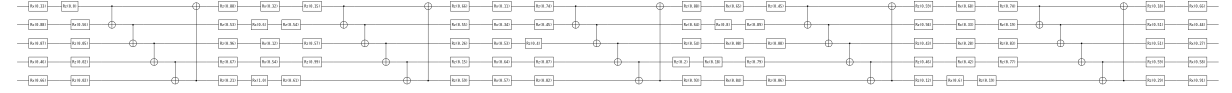

In [70]:
using Yao.EasyBuild
d = 5
circuit = dispatch!(variational_circuit(L, d),:random)
plot(circuit)

In [64]:
for i in 1:3000
      _, grad = expect'(h, zero_state(L) => circuit)
      dispatch!(-, circuit, 1e-2 * grad)
      println("Step $i, energy = $(real.(expect(h, zero_state(L)=>circuit)))")
end

Step 1, energy = -7.418587051325292
Step 2, energy = -7.418701108245884
Step 3, energy = -7.41881494415663
Step 4, energy = -7.418928559317242
Step 5, energy = -7.419041953988028
Step 6, energy = -7.419155128429878
Step 7, energy = -7.419268082904384
Step 8, energy = -7.419380817673687
Step 9, energy = -7.419493333000571
Step 10, energy = -7.419605629148431
Step 11, energy = -7.419717706381304
Step 12, energy = -7.4198295649637975
Step 13, energy = -7.419941205161179
Step 14, energy = -7.420052627239312
Step 15, energy = -7.420163831464643
Step 16, energy = -7.42027481810427
Step 17, energy = -7.420385587425889
Step 18, energy = -7.420496139697815
Step 19, energy = -7.420606475188945
Step 20, energy = -7.420716594168796
Step 21, energy = -7.420826496907498
Step 22, energy = -7.420936183675755
Step 23, energy = -7.421045654744894
Step 24, energy = -7.421154910386853
Step 25, energy = -7.421263950874119
Step 26, energy = -7.421372776479809
Step 27, energy = -7.421481387477641
Step 28, en

Step 264, energy = -7.441838055312829
Step 265, energy = -7.441904149468665
Step 266, energy = -7.4419701015727275
Step 267, energy = -7.442035911916706
Step 268, energy = -7.442101580791963
Step 269, energy = -7.442167108489406
Step 270, energy = -7.442232495299626
Step 271, energy = -7.442297741512848
Step 272, energy = -7.442362847418857
Step 273, energy = -7.442427813307091
Step 274, energy = -7.442492639466647
Step 275, energy = -7.442557326186154
Step 276, energy = -7.4426218737539065
Step 277, energy = -7.442686282457823
Step 278, energy = -7.442750552585395
Step 279, energy = -7.442814684423726
Step 280, energy = -7.442878678259546
Step 281, energy = -7.442942534379184
Step 282, energy = -7.443006253068565
Step 283, energy = -7.443069834613215
Step 284, energy = -7.443133279298243
Step 285, energy = -7.443196587408393
Step 286, energy = -7.443259759227992
Step 287, energy = -7.4433227950409275
Step 288, energy = -7.44338569513072
Step 289, energy = -7.443448459780469
Step 290, 

Step 636, energy = -7.4587586582813366
Step 637, energy = -7.4587882572075825
Step 638, energy = -7.458817792083088
Step 639, energy = -7.458847263042639
Step 640, energy = -7.458876670220716
Step 641, energy = -7.458906013751508
Step 642, energy = -7.458935293768895
Step 643, energy = -7.458964510406465
Step 644, energy = -7.458993663797452
Step 645, energy = -7.45902275407487
Step 646, energy = -7.459051781371356
Step 647, energy = -7.45908074581928
Step 648, energy = -7.459109647550721
Step 649, energy = -7.459138486697416
Step 650, energy = -7.459167263390868
Step 651, energy = -7.459195977762236
Step 652, energy = -7.4592246299424065
Step 653, energy = -7.459253220061932
Step 654, energy = -7.459281748251122
Step 655, energy = -7.45931021463995
Step 656, energy = -7.459338619358127
Step 657, energy = -7.459366962535043
Step 658, energy = -7.459395244299827
Step 659, energy = -7.45942346478129
Step 660, energy = -7.459451624107964
Step 661, energy = -7.459479722408101
Step 662, ene

Step 1022, energy = -7.466477745235758
Step 1023, energy = -7.466490356384151
Step 1024, energy = -7.466502939014956
Step 1025, energy = -7.46651549318925
Step 1026, energy = -7.466528018967955
Step 1027, energy = -7.466540516411965
Step 1028, energy = -7.46655298558199
Step 1029, energy = -7.466565426538626
Step 1030, energy = -7.466577839342398
Step 1031, energy = -7.466590224053649
Step 1032, energy = -7.466602580732679
Step 1033, energy = -7.4666149094395955
Step 1034, energy = -7.466627210234454
Step 1035, energy = -7.46663948317716
Step 1036, energy = -7.4666517283275216
Step 1037, energy = -7.466663945745217
Step 1038, energy = -7.466676135489835
Step 1039, energy = -7.4666882976208
Step 1040, energy = -7.466700432197488
Step 1041, energy = -7.466712539279109
Step 1042, energy = -7.466724618924776
Step 1043, energy = -7.466736671193494
Step 1044, energy = -7.466748696144156
Step 1045, energy = -7.466760693835524
Step 1046, energy = -7.4667726643262755
Step 1047, energy = -7.4667

Step 1419, energy = -7.469770178893421
Step 1420, energy = -7.469775239732713
Step 1421, energy = -7.469780288876311
Step 1422, energy = -7.469785326351533
Step 1423, energy = -7.469790352185671
Step 1424, energy = -7.469795366405869
Step 1425, energy = -7.469800369039289
Step 1426, energy = -7.4698053601130265
Step 1427, energy = -7.469810339654064
Step 1428, energy = -7.469815307689406
Step 1429, energy = -7.4698202642459055
Step 1430, energy = -7.469825209350436
Step 1431, energy = -7.4698301430297755
Step 1432, energy = -7.469835065310654
Step 1433, energy = -7.469839976219724
Step 1434, energy = -7.469844875783604
Step 1435, energy = -7.469849764028843
Step 1436, energy = -7.469854640981933
Step 1437, energy = -7.469859506669306
Step 1438, energy = -7.469864361117342
Step 1439, energy = -7.469869204352372
Step 1440, energy = -7.469874036400624
Step 1441, energy = -7.469878857288333
Step 1442, energy = -7.469883667041637
Step 1443, energy = -7.469888465686612
Step 1444, energy = -7

Step 1734, energy = -7.470905465080132
Step 1735, energy = -7.47090792588776
Step 1736, energy = -7.470910381167064
Step 1737, energy = -7.4709128309312955
Step 1738, energy = -7.470915275193681
Step 1739, energy = -7.4709177139674185
Step 1740, energy = -7.47092014726566
Step 1741, energy = -7.470922575101548
Step 1742, energy = -7.470924997488173
Step 1743, energy = -7.4709274144386155
Step 1744, energy = -7.470929825965907
Step 1745, energy = -7.470932232083067
Step 1746, energy = -7.470934632803028
Step 1747, energy = -7.470937028138773
Step 1748, energy = -7.4709394181032005
Step 1749, energy = -7.470941802709205
Step 1750, energy = -7.4709441819696325
Step 1751, energy = -7.47094655589729
Step 1752, energy = -7.470948924504971
Step 1753, energy = -7.47095128780545
Step 1754, energy = -7.470953645811439
Step 1755, energy = -7.470955998535644
Step 1756, energy = -7.470958345990731
Step 1757, energy = -7.470960688189331
Step 1758, energy = -7.470963025144057
Step 1759, energy = -7.4

Step 1948, energy = -7.471324974622049
Step 1949, energy = -7.471326508958633
Step 1950, energy = -7.47132803998361
Step 1951, energy = -7.471329567704875
Step 1952, energy = -7.471331092130249
Step 1953, energy = -7.471332613267598
Step 1954, energy = -7.471334131124728
Step 1955, energy = -7.471335645709431
Step 1956, energy = -7.471337157029469
Step 1957, energy = -7.471338665092625
Step 1958, energy = -7.471340169906616
Step 1959, energy = -7.47134167147916
Step 1960, energy = -7.471343169817963
Step 1961, energy = -7.471344664930718
Step 1962, energy = -7.471346156825041
Step 1963, energy = -7.471347645508622
Step 1964, energy = -7.471349130989066
Step 1965, energy = -7.47135061327396
Step 1966, energy = -7.471352092370936
Step 1967, energy = -7.471353568287507
Step 1968, energy = -7.471355041031254
Step 1969, energy = -7.4713565106096995
Step 1970, energy = -7.471357977030358
Step 1971, energy = -7.471359440300704
Step 1972, energy = -7.471360900428236
Step 1973, energy = -7.4713

Step 2343, energy = -7.471737356885495
Step 2344, energy = -7.471738037148117
Step 2345, energy = -7.471738716083624
Step 2346, energy = -7.471739393694964
Step 2347, energy = -7.4717400699850725
Step 2348, energy = -7.471740744956914
Step 2349, energy = -7.471741418613407
Step 2350, energy = -7.471742090957496
Step 2351, energy = -7.471742761992063
Step 2352, energy = -7.471743431720059
Step 2353, energy = -7.4717441001443845
Step 2354, energy = -7.47174476726793
Step 2355, energy = -7.471745433093575
Step 2356, energy = -7.471746097624224
Step 2357, energy = -7.4717467608627395
Step 2358, energy = -7.471747422811994
Step 2359, energy = -7.471748083474861
Step 2360, energy = -7.471748742854196
Step 2361, energy = -7.471749400952826
Step 2362, energy = -7.471750057773614
Step 2363, energy = -7.471750713319388
Step 2364, energy = -7.471751367592988
Step 2365, energy = -7.471752020597207
Step 2366, energy = -7.4717526723348895
Step 2367, energy = -7.4717533228088335
Step 2368, energy = -

Step 2565, energy = -7.471860495054362
Step 2566, energy = -7.471860941792977
Step 2567, energy = -7.471861387711855
Step 2568, energy = -7.471861832812724
Step 2569, energy = -7.471862277097317
Step 2570, energy = -7.471862720567346
Step 2571, energy = -7.471863163224521
Step 2572, energy = -7.471863605070546
Step 2573, energy = -7.4718640461071395
Step 2574, energy = -7.471864486336
Step 2575, energy = -7.471864925758822
Step 2576, energy = -7.4718653643772965
Step 2577, energy = -7.471865802193114
Step 2578, energy = -7.471866239207964
Step 2579, energy = -7.47186667542352
Step 2580, energy = -7.471867110841468
Step 2581, energy = -7.471867545463489
Step 2582, energy = -7.471867979291235
Step 2583, energy = -7.471868412326383
Step 2584, energy = -7.471868844570581
Step 2585, energy = -7.471869276025498
Step 2586, energy = -7.471869706692788
Step 2587, energy = -7.471870136574107
Step 2588, energy = -7.4718705656710735
Step 2589, energy = -7.471870993985369
Step 2590, energy = -7.471

Step 2982, energy = -7.47199221037534
Step 2983, energy = -7.471992426440166
Step 2984, energy = -7.4719926421473675
Step 2985, energy = -7.471992857497612
Step 2986, energy = -7.471993072491551
Step 2987, energy = -7.471993287129859
Step 2988, energy = -7.47199350141321
Step 2989, energy = -7.47199371534226
Step 2990, energy = -7.471993928917676
Step 2991, energy = -7.47199414214011
Step 2992, energy = -7.471994355010226
Step 2993, energy = -7.471994567528685
Step 2994, energy = -7.471994779696143
Step 2995, energy = -7.471994991513249
Step 2996, energy = -7.471995202980672
Step 2997, energy = -7.471995414099066
Step 2998, energy = -7.4719956248690504
Step 2999, energy = -7.4719958352913025
Step 3000, energy = -7.471996045366475


the expectation function `expect` is differentiable, thus you can use a simple `'` mark to get the graident of it, e.g

In [67]:
reg, grad = expect'(Z, zero_state(1)=>Rx(0.2))

ArrayReg{2, ComplexF64, Array...}
    active qubits: 1/1
    nlevel: 2 => [-0.19866933079506124]

In [68]:
grad

1-element Vector{Float64}:
 -0.19866933079506124

the gradient array follows the same order of `dispatch!`, or `parameters` function, so that we can apply the gradient back to optimize your parameters

## References for hands-on tasks

In [33]:
?operator_fidelity

search: operator_fidelity



```
operator_fidelity(b1::AbstractBlock, b2::AbstractBlock) -> Number
```

Operator fidelity defined as

$$
F(A, B) = \frac{1}{d}|{\rm Tr}(A^\dagger B)|
$$

Here, `d` is the size of the Hilbert space. Note this quantity is independant to global phase. See arXiv: 0803.2940v2, Equation (2) for reference.

### Examples

```jldoctest; setup=:(using Yao)
julia> operator_fidelity(X, X)
1.0

julia> operator_fidelity(X, Z)
0.0
```

---

```
operator_fidelity(b1::AbstractBlock, b2::AbstractBlock) -> Number
```

Operator fidelity defined as

$$
F^2 = \frac{1}{d^2}\left[{\rm Tr}(b1^\dagger b2)\right]
$$

Here, `d` is the size of the Hilbert space. Note this quantity is independant to global phase. See arXiv: 0803.2940v2, Equation (2) for reference.


In [35]:
?time_evolve

search: time_evolve



```
time_evolve(H, dt[; tol=1e-7, check_hermicity=true])
```

Create a [`TimeEvolution`](@ref) block with Hamiltonian `H` and time step `dt`. The `TimeEvolution` block will use Krylove based `expv` to calculate time propagation. `TimeEvolution` block can also be used for [imaginary time evolution](http://large.stanford.edu/courses/2008/ph372/behroozi2/) if `dt` is complex. Let $H$ be a hamiltonian and $t$ be a time, the matrix representation of `time_evolve(H, t)` is $e^{-iHt}$.

### Arguments

  * `H` the hamiltonian represented as an `AbstractBlock`.
  * `dt`: the evolution duration (start time is zero).

### Keyword Arguments

  * `tol::Real=1e-7`: error tolerance.
  * `check_hermicity=true`: check hermicity or not.

### Examples

```jldoctest; setup=:(using Yao)
julia> time_evolve(kron(2, 1=>X, 2=>X), 0.1)
Time Evolution Δt = 0.1, tol = 1.0e-7
kron
├─ 1=>X
└─ 2=>X
```


In [36]:
using KrylovKit

In [37]:
?KrylovKit

search: KrylovKit



```
KrylovKit
```

A Julia package collecting a number of Krylov-based algorithms for linear problems, singular value and eigenvalue problems and the application of functions of linear maps or operators to vectors.

KrylovKit accepts general functions or callable objects as linear maps, and general Julia objects with vector like behavior as vectors.

The high level interface of KrylovKit is provided by the following functions:

  * [`linsolve`](@ref): solve linear systems
  * [`eigsolve`](@ref): find a few eigenvalues and corresponding eigenvectors
  * [`geneigsolve`](@ref): find a few generalized eigenvalues and corresponding vectors
  * [`svdsolve`](@ref): find a few singular values and corresponding left and right singular vectors
  * [`exponentiate`](@ref): apply the exponential of a linear map to a vector
  * [`expintegrator`](@ref): exponential integrator for a linear non-homogeneous ODE, computes a linear combination of the `ϕⱼ` functions which generalize `ϕ₀(z) = exp(z)`.


In [38]:
?eigsolve

search: eigsolve geneigsolve



```
eigsolve(A::AbstractMatrix, [x₀, howmany = 1, which = :LM, T = eltype(A)]; kwargs...)
eigsolve(f, n::Int, [howmany = 1, which = :LM, T = Float64]; kwargs...)
eigsolve(f, x₀, [howmany = 1, which = :LM]; kwargs...)
# expert version:
eigsolve(f, x₀, howmany, which, algorithm)
```

Compute at least `howmany` eigenvalues from the linear map encoded in the matrix `A` or by the function `f`. Return eigenvalues, eigenvectors and a `ConvergenceInfo` structure.

### Arguments:

The linear map can be an `AbstractMatrix` (dense or sparse) or a general function or callable object. If an `AbstractMatrix` is used, a starting vector `x₀` does not need to be provided, it is then chosen as `rand(T, size(A,1))`. If the linear map is encoded more generally as a a callable function or method, the best approach is to provide an explicit starting guess `x₀`. Note that `x₀` does not need to be of type `AbstractVector`; any type that behaves as a vector and supports the required methods (see KrylovKit docs) is accepted. If instead of `x₀` an integer `n` is specified, it is assumed that `x₀` is a regular vector and it is initialized to `rand(T,n)`, where the default value of `T` is `Float64`, unless specified differently.

The next arguments are optional, but should typically be specified. `howmany` specifies how many eigenvalues should be computed; `which` specifies which eigenvalues should be targeted. Valid specifications of `which` are given by

  * `:LM`: eigenvalues of largest magnitude
  * `:LR`: eigenvalues with largest (most positive) real part
  * `:SR`: eigenvalues with smallest (most negative) real part
  * `:LI`: eigenvalues with largest (most positive) imaginary part, only if `T <: Complex`
  * `:SI`: eigenvalues with smallest (most negative) imaginary part, only if `T <: Complex`
  * [`EigSorter(f; rev = false)`](@ref): eigenvalues `λ` that appear first (or last if `rev == true`) when sorted by `f(λ)`

!!! note "Note about selecting `which` eigenvalues"
    Krylov methods work well for extremal eigenvalues, i.e. eigenvalues on the periphery of the spectrum of the linear map. All of they valid `Symbol`s for `which` have this property, but could also be specified using `EigSorter`, e.g. `:LM` is equivalent to `Eigsorter(abs; rev = true)`. Note that smallest magnitude sorting is obtained using e.g. `EigSorter(abs; rev = false)`, but since no (shift-and)-invert is used, this will only be successful if you somehow know that eigenvalues close to zero are also close to the periphery of the spectrum.


!!! warning "Degenerate eigenvalues"
    From a theoretical point of view, Krylov methods can at most find a single eigenvector associated with a targetted eigenvalue, even if the latter is degenerate. In the case of a degenerate eigenvalue, the specific eigenvector that is returned is determined by the starting vector `x₀`. For large problems, this turns out to be less of an issue in practice, as often a second linearly independent eigenvector is generated out of the numerical noise resulting from the orthogonalisation steps in the Lanczos or Arnoldi iteration. Nonetheless, it is important to take this into account and to try not to depend on this potentially fragile behaviour, especially for smaller problems.


The argument `T` acts as a hint in which `Number` type the computation should be performed, but is not restrictive. If the linear map automatically produces complex values, complex arithmetic will be used even though `T<:Real` was specified. However, if the linear map and initial guess are real, approximate eigenvalues will be searched for using a partial Schur factorization, which implies that complex conjugate eigenvalues come in pairs and cannot be split. It is then illegal to choose `which` in a way that would treat `λ` and `conj(λ)` differently, i.e. `:LI` and `:SI` are invalid, as well as any `EigSorter` that would lead to `by(λ) != by(conj(λ))`.

### Return values:

The return value is always of the form `vals, vecs, info = eigsolve(...)` with

  * `vals`: a `Vector` containing the eigenvalues, of length at least `howmany`, but could be longer if more eigenvalues were converged at the same cost. Eigenvalues will be real if [`Lanczos`](@ref) was used and complex if [`Arnoldi`](@ref) was used (see below).
  * `vecs`: a `Vector` of corresponding eigenvectors, of the same length as `vals`. Note that eigenvectors are not returned as a matrix, as the linear map could act on any custom Julia type with vector like behavior, i.e. the elements of the list `vecs` are objects that are typically similar to the starting guess `x₀`, up to a possibly different `eltype`. In particular  for a general matrix (i.e. with `Arnoldi`) the eigenvectors are generally complex and are therefore always returned in a complex number format. When the linear map is a simple `AbstractMatrix`, `vecs` will be `Vector{Vector{<:Number}}`.
  * `info`: an object of type [`ConvergenceInfo`], which has the following fields

      * `info.converged::Int`: indicates how many eigenvalues and eigenvectors were actually converged to the specified tolerance `tol` (see below under keyword arguments)
      * `info.residual::Vector`: a list of the same length as `vals` containing the residuals `info.residual[i] = f(vecs[i]) - vals[i] * vecs[i]`
      * `info.normres::Vector{<:Real}`: list of the same length as `vals` containing the norm of the residual `info.normres[i] = norm(info.residual[i])`
      * `info.numops::Int`: number of times the linear map was applied, i.e. number of times `f` was called, or a vector was multiplied with `A`
      * `info.numiter::Int`: number of times the Krylov subspace was restarted (see below)

!!! warning "Check for convergence"
    No warning is printed if not all requested eigenvalues were converged, so always check if `info.converged >= howmany`.


### Keyword arguments:

Keyword arguments and their default values are given by:

  * `verbosity::Int = 0`: verbosity level, i.e. 0 (no messages), 1 (single message at the end), 2 (information after every iteration), 3 (information per Krylov step)
  * `tol::Real`: the requested accuracy (corresponding to the 2-norm of the residual for Schur vectors, not the eigenvectors). If you work in e.g. single precision (`Float32`), you should definitely change the default value.
  * `krylovdim::Integer`: the maximum dimension of the Krylov subspace that will be constructed. Note that the dimension of the vector space is not known or checked, e.g. `x₀` should not necessarily support the `Base.length` function. If you know the actual problem dimension is smaller than the default value, it is useful to reduce the value of `krylovdim`, though in principle this should be detected.
  * `maxiter::Integer`: the number of times the Krylov subspace can be rebuilt; see below for further details on the algorithms.
  * `orth::Orthogonalizer`: the orthogonalization method to be used, see [`Orthogonalizer`](@ref)
  * `issymmetric::Bool`: if the linear map is symmetric, only meaningful if `T<:Real`
  * `ishermitian::Bool`: if the linear map is hermitian
  * `eager::Bool = false`: if true, eagerly compute the eigenvalue or Schur decomposition after every expansion of the Krylov subspace to test for convergence, otherwise wait until the Krylov subspace has dimension `krylovdim`. This can result in a faster return, for example if the initial guess is very good, but also has some overhead, as many more dense Schur factorizations need to be computed.

The default values are given by `tol = KrylovDefaults.tol`, `krylovdim = KrylovDefaults.krylovdim`, `maxiter = KrylovDefaults.maxiter`, `orth = KrylovDefaults.orth`; see [`KrylovDefaults`](@ref) for details.

The default value for the last two parameters depends on the method. If an `AbstractMatrix` is used, `issymmetric` and `ishermitian` are checked for that matrix, otherwise the default values are `issymmetric = false` and `ishermitian = T <: Real && issymmetric`. When values for the keyword arguments are provided, no checks will be performed even in the matrix case.

### Algorithm

The final (expert) method, without default values and keyword arguments, is the one that is finally called, and can also be used directly. Here, one specifies the algorithm explicitly as either [`Lanczos`](@ref), for real symmetric or complex hermitian problems, or [`Arnoldi`](@ref), for general problems. Note that these names refer to the process for building the Krylov subspace, but the actual algorithm is an implementation of the Krylov-Schur algorithm, which can dynamically shrink and grow the Krylov subspace, i.e. the restarts are so-called thick restarts where a part of the current Krylov subspace is kept.

!!! note "Note about convergence"
    In case of a general problem, where the `Arnoldi` method is used, convergence of an eigenvalue is not based on the norm of the residual `norm(f(vecs[i]) - vals[i]*vecs[i])` for the eigenvector but rather on the norm of the residual for the corresponding Schur vectors.

    See also [`schursolve`](@ref) if you want to use the partial Schur decomposition directly, or if you are not interested in computing the eigenvectors, and want to work in real arithmetic all the way true (if the linear map and starting guess are real).



`P1` gate is the same as `n` operator

In [77]:
Const.P1

2×2 Diagonal{ComplexF64, Vector{ComplexF64}}:
 0.0+0.0im      ⋅    
     ⋅      1.0+0.0im

In [78]:
ConstGate.P1

P1